# Reviews - The 🗡 Nemesis 🗡 of Top Games (pt. 2)
---

## Sentimental Analysis - Free Apps Reviews

The analysis of Top Free App Reviews will use the BERT model from [HuggingFace](https://huggingface.co/) library with [PyTorch](https://pytorch.org/docs/stable/index.html) as the machine learning library. 

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import transformers
import seaborn as sns
import torch
import pprint

from collections import defaultdict
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)


# utilizes NVIDIA GPU to run machine learning models unless it is not avabile
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cpu


## Data Properties
The scraped data should have no trouble with the machine learning model, training, and analysis. Let's look at some properties of the dataset.

In [2]:
# load data
free_df = pd.read_csv('free_app_review.csv')

print(f'{free_df.shape[0]} rows x {free_df.shape[1]} columns')
free_df.head(3)

11532 rows x 12 columns


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appID,sort
0,gp:AOqpTOFgjr8RgQcyKn7EYWvtatg0b2LEBkGb8Gigbgp...,Abid Rahman,https://play-lh.googleusercontent.com/a-/AOh14...,"Nice game, but 1 star because there are some i...",1,82,2020.11.17,2021-01-19 20:40:36,NaN,NaN,com.innersloth.spacemafia,Most Relevant
1,gp:AOqpTOGFzP8HPhJSgiIPzHBeFAnihrTyJC_0a_3AZFt...,Agastya Garg,https://play-lh.googleusercontent.com/a-/AOh14...,There is a persisting issue which has made me ...,1,1894,2020.11.17,2021-01-09 23:48:16,NaN,NaN,com.innersloth.spacemafia,Most Relevant
2,gp:AOqpTOGE6IhF7bJGjK7wddBZhAtfoJRbtA_l4nTO6zE...,Kate Myob,https://play-lh.googleusercontent.com/-OAwXBxA...,"I love the PC version of this game, but on And...",1,2419,2020.11.17,2020-11-26 10:38:24,NaN,NaN,com.innersloth.spacemafia,Most Relevant


In [3]:
free_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11532 entries, 0 to 11531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reviewId              11532 non-null  object 
 1   userName              11532 non-null  object 
 2   userImage             11532 non-null  object 
 3   content               11532 non-null  object 
 4   score                 11532 non-null  int64  
 5   thumbsUpCount         11532 non-null  int64  
 6   reviewCreatedVersion  9004 non-null   object 
 7   at                    11532 non-null  object 
 8   replyContent          0 non-null      float64
 9   repliedAt             0 non-null      float64
 10  appID                 11532 non-null  object 
 11  sort                  11532 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 1.1+ MB


There are over 11k data that contains user reviews for these free games! And it doesn't seem like the dataset has any missing data. 


Next step is to look at the distribution plot for all ratings and determine whether the dataset is reasonable. 

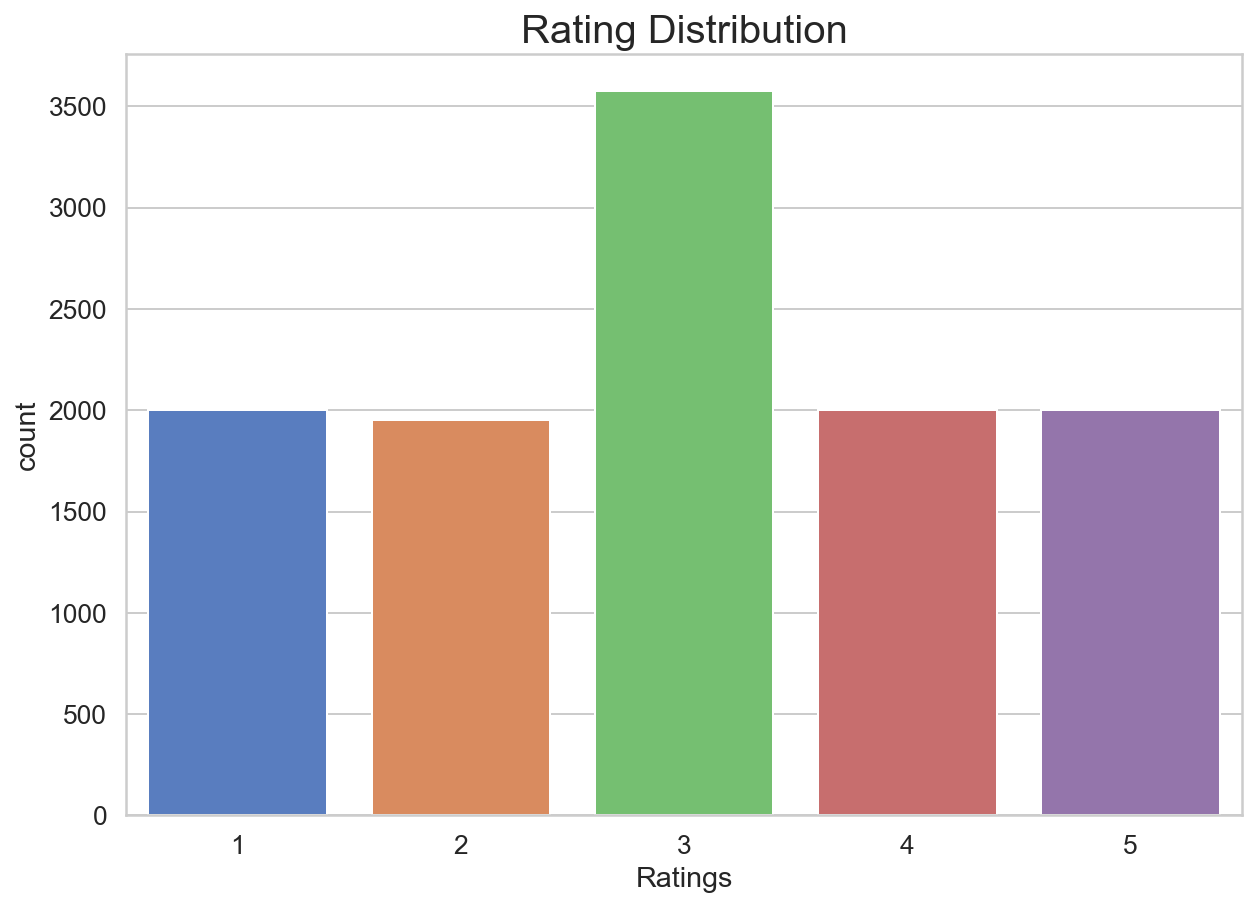

In [4]:
plt.figure(figsize=(10, 7))

sns.countplot(x=free_df['score'])
plt.title('Rating Distribution', size=20)
plt.xlabel('Ratings');

The distribution is as intended. It would be extremely difficult to run a sentiment analys predicting the ratings left by a given user, therefore a sentiment category should be defined.


For simplicity:

* `1 or 2 stars`: Negative
* `3 stars`: Neutral
* `4 or 5 stars`: Positive

In [5]:
def categorize(rating):
    rating = int(rating)
    
    if rating < 3:
        return 0
    
    elif rating == 3:
        return 1
        
    else: 
        return 2
    
free_df['sentiment'] = free_df['score'].apply(categorize)

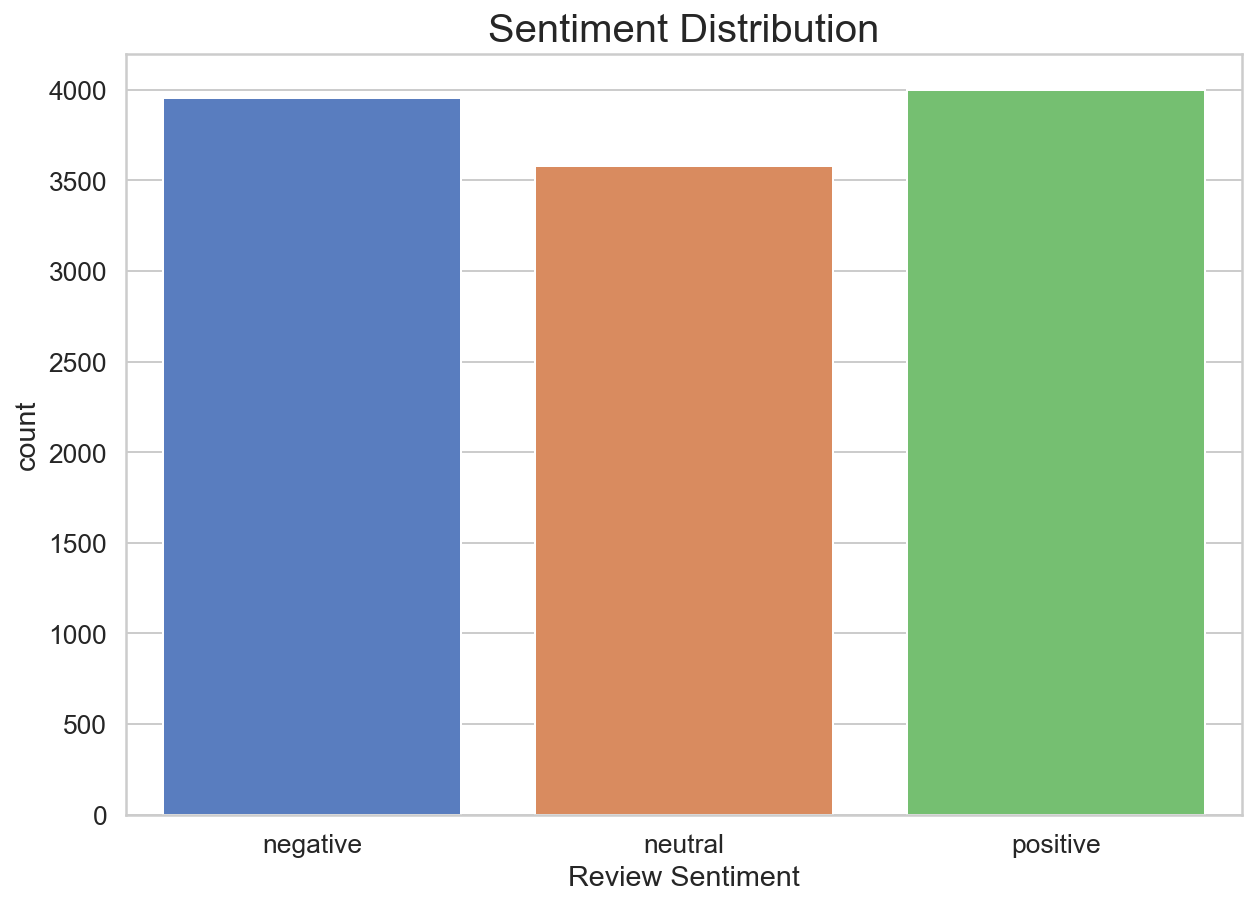

In [6]:
category = ['negative', 'neutral', 'positive']

plt.figure(figsize=(10, 7))
ax = sns.countplot(free_df['sentiment'])
plt.title('Sentiment Distribution', size=20)
plt.xlabel('Review Sentiment')
ax.set_xticklabels(category);

## Preprocessing Data

The sentiment distribution is relatively uniform which indicates there is a decent balance in the data that would be fed into the model. But first the data must be preprocessed. 

### Special Tokens
BERT has some special tokens that will be used in the training and modeling.

- `[SEP]` is a token used as a sequence separator
- `[CLS]` is a token used to do sequence classification
- `[PAD]` is a token for padding when batching different length sequences
- `[UNK]` is a token that is not in the vocabulary

The tokens and their respective token IDs are shown below

In [7]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')

tokenizer.sep_token, tokenizer.sep_token_id
tokenizer.cls_token, tokenizer.cls_token_id
tokenizer.pad_token, tokenizer.pad_token_id
tokenizer.unk_token, tokenizer.unk_token_id

print(f'Separation Token: {tokenizer.sep_token}, Separation Token ID: {tokenizer.sep_token_id}')
print(f'Classification Token: {tokenizer.cls_token}, Classification Token ID: {tokenizer.cls_token_id}')
print(f'Padding Token: {tokenizer.pad_token}, Padding Token ID: {tokenizer.pad_token_id}')
print(f'Unknown Token: {tokenizer.unk_token}, Unknown Token ID: {tokenizer.unk_token_id}')

Separation Token: [SEP], Separation Token ID: 102
Classification Token: [CLS], Classification Token ID: 101
Padding Token: [PAD], Padding Token ID: 0
Unknown Token: [UNK], Unknown Token ID: 100


### Sequence Length
The sequence length can be determined by looking at the distribution of token lengths. BERT can analyze a max length of 512; and the sequence length is necessary since BERT works with fixed-length sequences. The longer the sequence  length, the longer it takes for the model to train.  

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


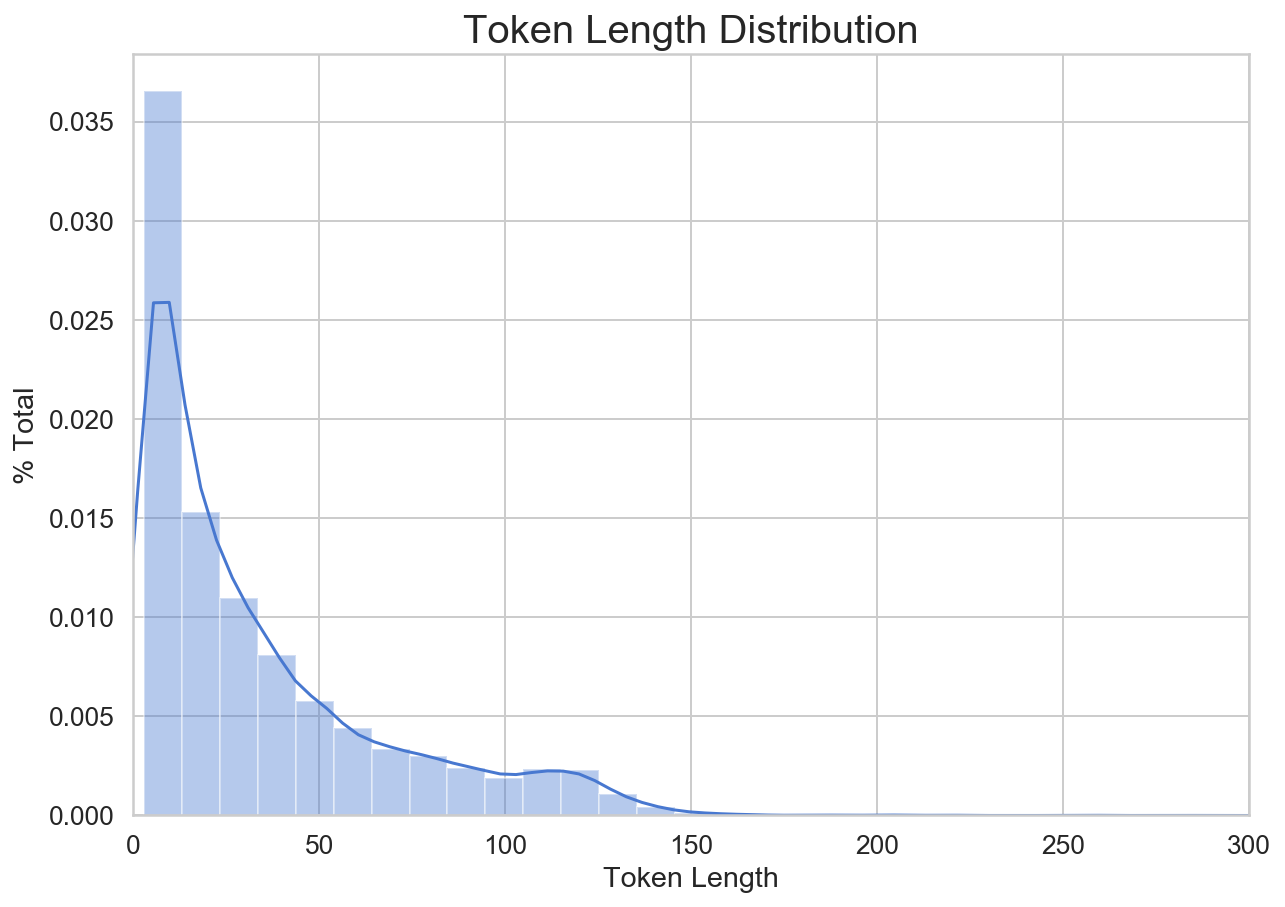

In [8]:
token_length = []

for txt in free_df['content']:
    tokens = tokenizer.encode(txt, max_length=512);
    token_length.append(len(tokens))
    
plt.figure(figsize=(10, 7))
plt.xlim([0, 300])
plt.xlabel('Token Length')
plt.ylabel('% Total')
plt.title('Token Length Distribution', size=20)
sns.distplot(token_length);

Most token lengths are approximately within 150, so let's choose a sequence length of 160 to capture 99% of the data.

In [9]:
MAX_LEN = 160
BATCH_SIZE = 16
EPOCHS = 15

### Create a Dataset

Now the parameters have been set, the next step is to create a dataset to train the data. PyTorch functions will be used to create the `map-style-datasets` dataset, which is a dictionary. 

`Map-style datasets` implements `__len__()` and `__getitem__()` protocols.

In [10]:
class GPReviewDataset(Dataset):
    
    # sets the parameters of the map-style-dataset
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    # returns the length of the dataset    
    def __len__(self):
        return len(self.reviews)
    
    # access the idx-th item from the input data
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # tokenizes the data
        encoding = self.tokenizer.encode_plus(text=review, 
                                              max_length=self.max_len,
                                              add_special_tokens=True, # adds [CLS] and [SEP]
                                              padding='max_length', # pad to max length
                                              truncation=True, # truncate to max length
                                              return_attention_mask=True, 
                                              return_token_type_ids=False, 
                                              return_tensors='pt'); # return PyTorch tensors
        
        # return dictionary
        return {'review': review,
                'input_ids': encoding['input_ids'].flatten(), 
                'attention_mask': encoding['attention_mask'].flatten(),
                'targets': torch.tensor(target, dtype=torch.long)}

Now is a good time to double check the output is the desired output

In [11]:
pprint.pprint(GPReviewDataset(reviews=free_df['content'].to_numpy(),
                      targets=free_df['sentiment'].to_numpy(), 
                      tokenizer=tokenizer,
                      max_len=MAX_LEN).__getitem__(0))

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'input_ids': tensor([  101,  8835,  1342,   117,  1133,   122,  2851,  1272,  1175,  1132,
         1199,  7210, 19959, 10934,  5796,  2463,   117,  6064,  1339,  1292,
         2645,   117,  1463,  7210,  3797,  1110,  2503,   119,  1262,  1164,
         1103, 22572,  5026,  1766, 13287,  2463,   117,  1142,  1110, 12277,
          117,  1463,  1122,  1169,  1129,  1454,  1191,  2087,   117,  1133,
         1242,  1234,  2144,   112,   1

The output looks good to go. Time to split the data for training, validation, and testing sets. 

* Training: Data used to train the model.
* Validation: Data used to assist the training model. Ensure the training model does not overfit. 
* Testing: Data used to test the trained model.

Typically the training to testing ratio is 80:20. However through trial and error and testing different arguments, the best ratio was 90:10.

In [12]:
# 20% random samples split into testing; 80% split into training
free_df_train, free_df_test = train_test_split(free_df, test_size=0.1)

# 50% of the 20% from testing data is split into random samples of validation
free_df_val, free_df_test = train_test_split(free_df_test, test_size=0.5)

print(f'Trainig:  {free_df_train.shape[0]} x {free_df_train.shape[1]}')
print(f'Validation:  {free_df_val.shape[0]} x {free_df_val.shape[1]}')
print(f'Testing:  {free_df_test.shape[0]} x {free_df_test.shape[1]}')

Trainig:  10378 x 13
Validation:  577 x 13
Testing:  577 x 13


A data loader is then needed to load the different data sets - training, validation, and testing

In [13]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(reviews=df['content'].to_numpy(), 
                         targets=df['sentiment'].to_numpy(),
                         tokenizer=tokenizer, 
                         max_len=max_len)
    
    return DataLoader(ds, batch_size=batch_size, num_workers=0)
    '''
    there is an error with `num_workers` having broken pipe error if the argument is > 1
    the `num_workers` doesn't change the outcome other than the efficiency of the code
    '''

In [14]:
train_data_loader = create_data_loader(free_df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(free_df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(free_df_test, tokenizer, MAX_LEN, BATCH_SIZE)

data = next(iter(train_data_loader))
data.keys()

dict_keys(['review', 'input_ids', 'attention_mask', 'targets'])

## Sentiment Classifier

The sentiment classifier will contain the neural network that will define BERT's parameters. The neural network would utilize the classifier to train and test the model. 

In [15]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_class):
        super(SentimentClassifier, self).__init__()
        self.bert = transformers.BertModel.from_pretrained('bert-base-cased')
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_class)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        output = self.drop(pooled_output)
        return self.out(output)

In [16]:
# 3 categories - negative, neutral, and positive        
model = SentimentClassifier(len(category))
model = model.to(device)

## Training
Define two functions `train_epoch` and `eval_model`.


`train_epoch` is a helper function that look over all training data for epochs and apply those to the sentiment.

`eval_model` evaluates the current model.

In [17]:
optimizer = transformers.AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

In [18]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    # loop over each example
    for i in data_loader:
        input_ids = i['input_ids'].to(device)
        attention_mask = i['attention_mask'].to(device)
        targets = i['targets'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1) # process with the highest probability
        loss = loss_fn(outputs, targets)
        
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # stabilize the gradient model
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad() # zero the gradients
        
    return correct_predictions.double() / n_examples, np.mean(losses)

In [19]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    
    # disable the gradient function for faster processing
    with torch.no_grad():
        
        # loop over each example
        for i in data_loader:
            input_ids = i['input_ids'].to(device)
            attention_mask = i['attention_mask'].to(device)
            targets = i['targets'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
            
    return correct_predictions.double() / n_examples, np.mean(losses)

In [56]:
%%time
# time the training process

# store the training loss, training accuracy, validation loss, and validation accuracy 
history = defaultdict(list)

# store the best accuracy
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1} / {EPOCHS}')
    print('-' * 20)
    
    train_acc, train_loss = train_epoch(model, train_data_loader, 
                                        loss_fn, optimizer,
                                        device, scheduler, 
                                        len(free_df_train))
    
    print(f'Train loss {train_loss} accuracy {train_acc}')
    
    val_acc, val_loss = eval_model(model, val_data_loader, 
                                   loss_fn, device,
                                   len(free_df_val))
    
    print(f'Val loss {val_loss} accuracy {val_acc}')
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'model.bin')
        best_accuracy = val_acc

Epoch 1 / 15
--------------------
Train loss 0.9049877836634456 accuracy 0.5585854692619002
Val loss 0.7166569555127943 accuracy 0.6863084922010398

Epoch 2 / 15
--------------------
Train loss 0.6628907659250342 accuracy 0.7179610714973983
Val loss 0.696399861090892 accuracy 0.6880415944540728

Epoch 3 / 15
--------------------
Train loss 0.4617442109425465 accuracy 0.8202929273463095
Val loss 0.7693055066707972 accuracy 0.729636048526863

Epoch 4 / 15
--------------------
Train loss 0.3342927156765307 accuracy 0.8787820389285026
Val loss 0.8975855137246687 accuracy 0.7227036395147314

Epoch 5 / 15
--------------------
Train loss 0.2616485275237754 accuracy 0.9040277510117556
Val loss 1.0706481503203158 accuracy 0.7365684575389948

Epoch 6 / 15
--------------------
Train loss 0.22536764127142778 accuracy 0.9191559067257661
Val loss 1.155995563660572 accuracy 0.7452339688041595

Epoch 7 / 15
--------------------
Train loss 0.1934084890484566 accuracy 0.9307188282906148
Val loss 1.19201

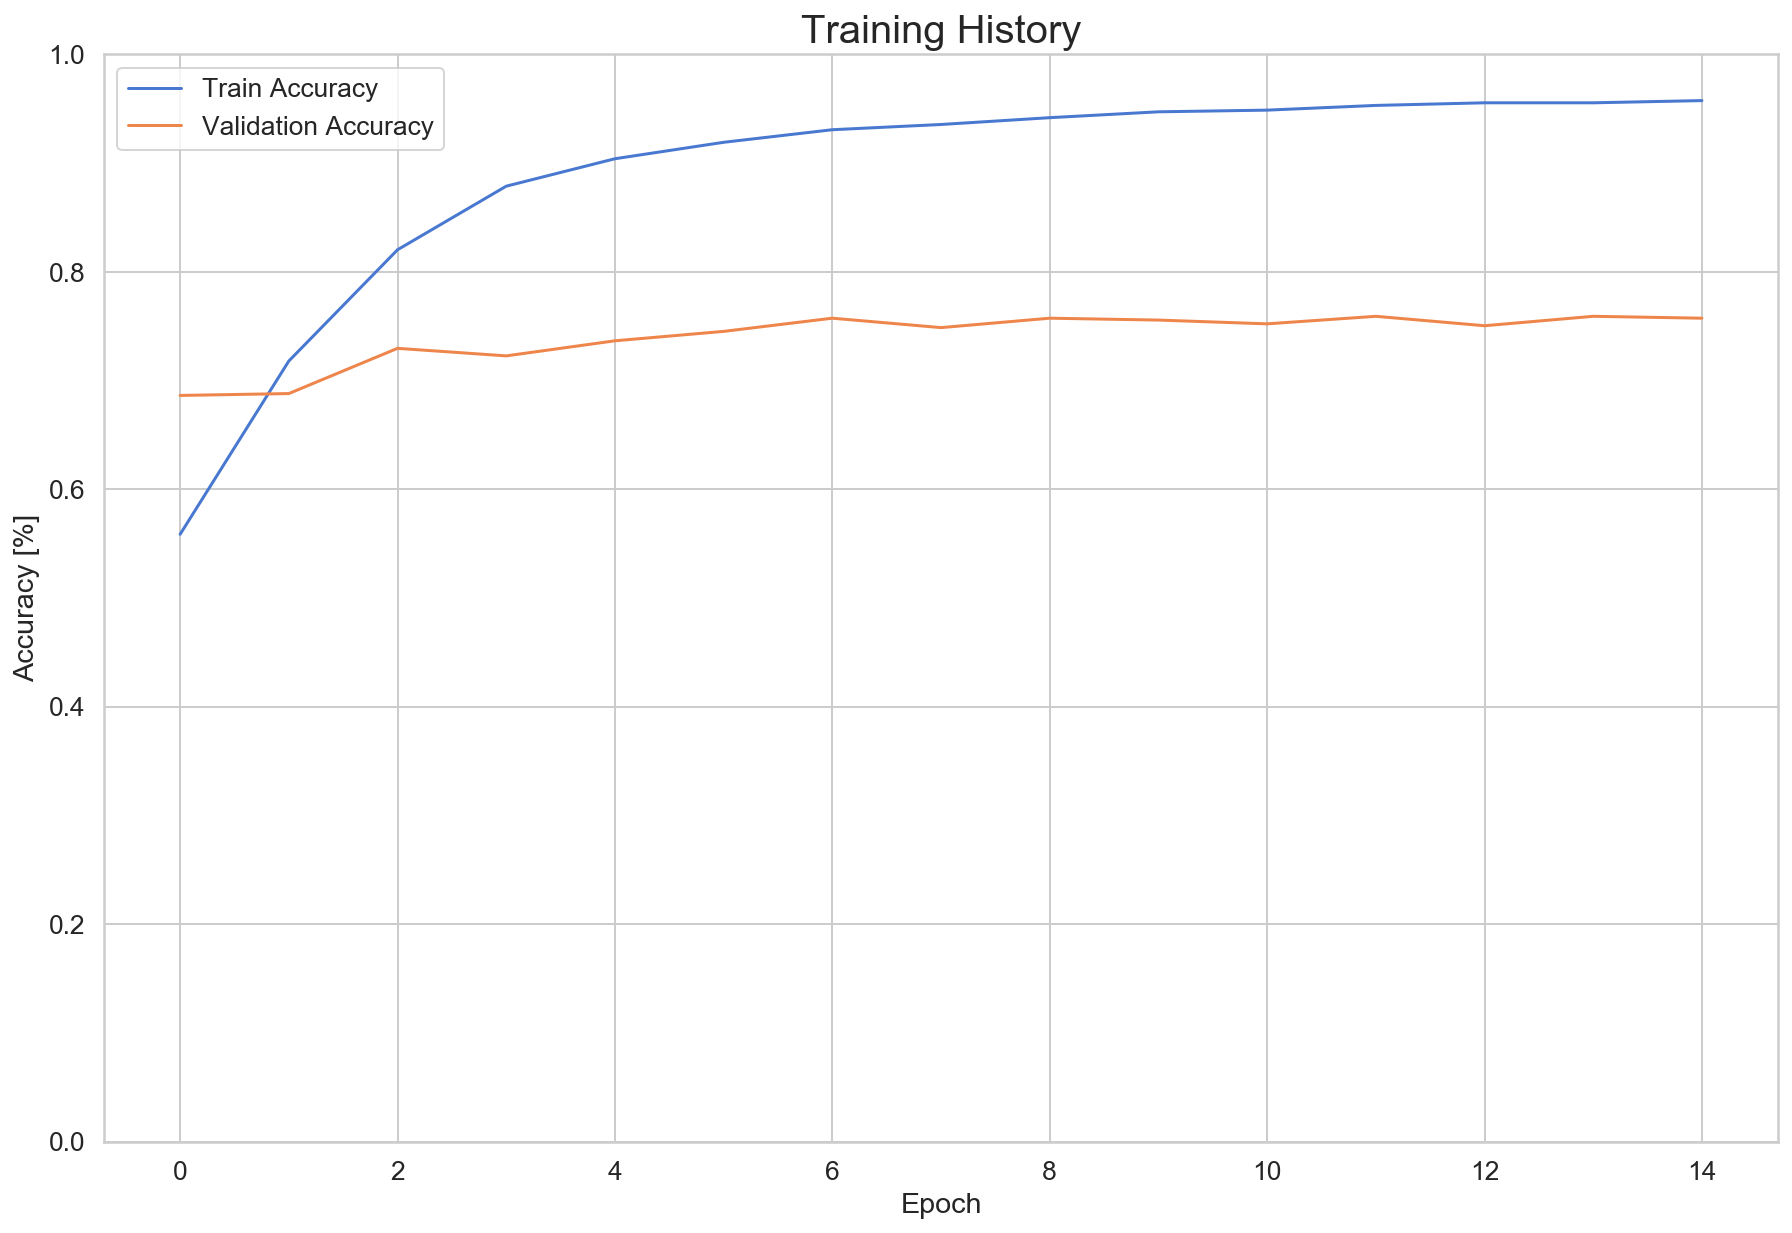

In [59]:
plt.figure(figsize=(15, 10))

plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')

plt.title('Training History', size=20)
plt.ylabel('Accuracy [%]')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## Evaluation

In [20]:
def get_reviews(model, data_loader):
    
    # evaluation model
    model = model.eval()
    
    reviews = []
    predictions = []
    prediction_probs = []
    real_values = []
    
    # 
    with torch.no_grad():
      
        # for each review
        for i in data_loader:
            
            texts = i['review']
            input_ids = i['input_ids'].to(device)
            attention_mask = i['attention_mask'].to(device)
            targets = i['targets'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            
            
            reviews.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
            
            
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    
    return reviews, predictions, prediction_probs, real_values

In [21]:
y_review_texts, y_preds, y_pred_probs, y_test = get_reviews(model, test_data_loader)